## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Activation, PReLU, Add

## Prepare data for model training

In [2]:
with open("../input/workation-price-prediction-preprocess-data/Workation_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']
train_df.drop(['Per Person Price'], inplace=True, axis=1)

del processed_data
gc.collect()

22

In [3]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
combined_df.head()

,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,pkg_embed_7,...,sightseeing_embed_764,sightseeing_embed_765,sightseeing_embed_766,sightseeing_embed_767,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination
0,5.199338,-0.523537,0.525330,-0.041413,0.325577,0.664287,1.159515,0.216204,-0.918498,0.932184,...,0.090452,1.824556,5.199337,-1.811457,0.199538,0.744694,-5.199338,-5.199338,-5.199338,-5.199338
1,-5.199338,5.199338,-0.555065,0.878430,-0.381567,-0.590949,0.907080,0.599936,-1.132444,-0.942439,...,2.183092,-0.493553,0.756333,-0.383024,-5.199338,1.192071,0.166367,0.081638,0.533636,-0.293986
2,-5.199338,0.401995,-1.275303,-0.602943,-0.552537,0.023839,-0.121995,-0.185480,0.844485,0.295512,...,-0.514923,1.023003,-1.625274,1.149742,-5.199338,0.744694,0.981540,0.949547,0.205941,0.558392
3,-5.199338,5.199338,-0.455640,1.773922,-0.396947,0.200818,-0.464007,1.418118,-0.357496,-0.869846,...,0.323363,-0.475214,-0.244757,-0.224329,-5.199338,0.744694,-0.085414,0.949547,-0.524976,-0.358833
4,-5.199338,5.199338,0.738089,-1.861434,-0.076604,-0.535539,-0.973443,-0.387078,-0.529301,0.728240,...,0.455640,0.778225,-1.236652,1.554269,-5.199338,-1.456896,-1.283836,-0.816150,0.908975,-1.031509


In [4]:
class SwapNoise(Sequence):

    def __init__(self, data, swap_perc=0.15, batch_size=128, shuffle=True):
        self.batch_size = batch_size
        self.data = data
        self.swap_perc = swap_perc
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        return self.data.shape[0] // self.batch_size


    def __getitem__(self, index):
        indices = [i for i in range(index*self.batch_size, 
                                    (index+1)*self.batch_size)]
        noisy = self.swap_noise(self.data[indices])
        return (noisy), self.data[indices]


    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.data)


    def get_data(self):
        return self.data


    def swap_noise(self, temp):
        for index in range(temp.shape[0]):            
            num_swaps = np.random.binomial(temp.shape[1], 
                                           self.swap_perc, 
                                           size=1)
            if num_swaps ==0:
                num_swaps=1

            swap_rvs = np.random.normal(size=num_swaps)
            positions_in_row = np.random.choice(a=range(2,temp.shape[1]), 
                                                size=num_swaps, 
                                                replace=False)
            temp[index, positions_in_row] = swap_rvs
        
        return temp

In [5]:
mini_batch_size = 128

train_, test_ = train_test_split(combined_df, test_size=0.25)
print("train_: {} \ntest_: {}".format(train_.shape, test_.shape))

Xtrain = SwapNoise(train_.values, swap_perc=0.15, 
                   batch_size=mini_batch_size, shuffle=True)
Xtest = SwapNoise(test_.values, swap_perc=0.15, 
                  batch_size=mini_batch_size, shuffle=True)

train_: (22498, 4728) 
test_: (7500, 4728)


## Build the model

In [6]:
def autoencoder(n_features, embed_dim=1536):

    x_input = Input(shape=(n_features, ), name='Encoder-Input')

    xe1 = Dense(units=3584, name='Encoder-Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(x_input)
    xe1 = BatchNormalization(name='Encoder-BatchNorm-1')(xe1)
    xe1 = Activation('swish', name='Encoder-Swish-1')(xe1)

    xe2 = Dense(units=2560, name='Encoder-Dense-2', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe1)
    xe2 = BatchNormalization(name='Encoder-BatchNorm-2')(xe2)
    xe2 = Activation('swish', name='Encoder-Swish-2')(xe2)
    
    xe3 = Dense(units=3584, name='Encoder-Dense-3', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe2)
    xe3 = BatchNormalization(name='Encoder-BatchNorm-3')(xe3)
    xe3 = Activation('swish', name='Encoder-Swish-3')(xe3)
    xe3 = Add(name='Encoder-Add-3')([xe1, xe3])

    xe3 = Dense(units=embed_dim, name='Embed-Dense', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe3)
    xe3 = BatchNormalization(name='Embed-BatchNorm')(xe3)
    embed = Activation('swish', name='Embedding')(xe3)
    
    xd1 = Dense(units=3584, name='Decoder-Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(embed)
    xd1 = BatchNormalization(name='Decoder-BatchNorm-1')(xd1)
    xd1 = Activation('swish', name='Decoder-Swish-1')(xd1)

    xd2 = Dense(units=2560, name='Decoder-Dense-2', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xd1)
    xd2 = BatchNormalization(name='Decoder-BatchNorm-2')(xd2)
    xd2 = Activation('swish', name='Decoder-Swish-2')(xd2)
    
    xd3 = Dense(units=3584, name='Decoder-Dense-3', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xd2)
    xd3 = BatchNormalization(name='Decoder-BatchNorm-3')(xd3)
    xd3 = Activation('swish', name='Decoder-Swish-3')(xd3)
    xd3 = Add(name='Decoder-Add-3')([xd1, xd3])

    x_output = Dense(units=n_features, name='Decoder-Output', 
                     kernel_initializer='he_uniform')(xd3)

    model = Model(inputs=x_input, outputs=x_output, name='Autoencoder_Model')
    return model

In [7]:
model = autoencoder(train_.shape[1])
model.compile(loss='mean_squared_error',
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

early = EarlyStopping(monitor="val_loss", mode="min", 
                      restore_best_weights=True, 
                      patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-6, patience=5, 
                              verbose=1, mode='min')

chk_point = ModelCheckpoint('./DAE_model.h5', 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')

In [8]:
model.summary()

Model: "Autoencoder_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      [(None, 4728)]       0                                            
__________________________________________________________________________________________________
Encoder-Dense-1 (Dense)         (None, 3584)         16948736    Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-BatchNorm-1 (BatchNorma (None, 3584)         14336       Encoder-Dense-1[0][0]            
__________________________________________________________________________________________________
Encoder-Swish-1 (Activation)    (None, 3584)         0           Encoder-BatchNorm-1[0][0]        
__________________________________________________________________________________

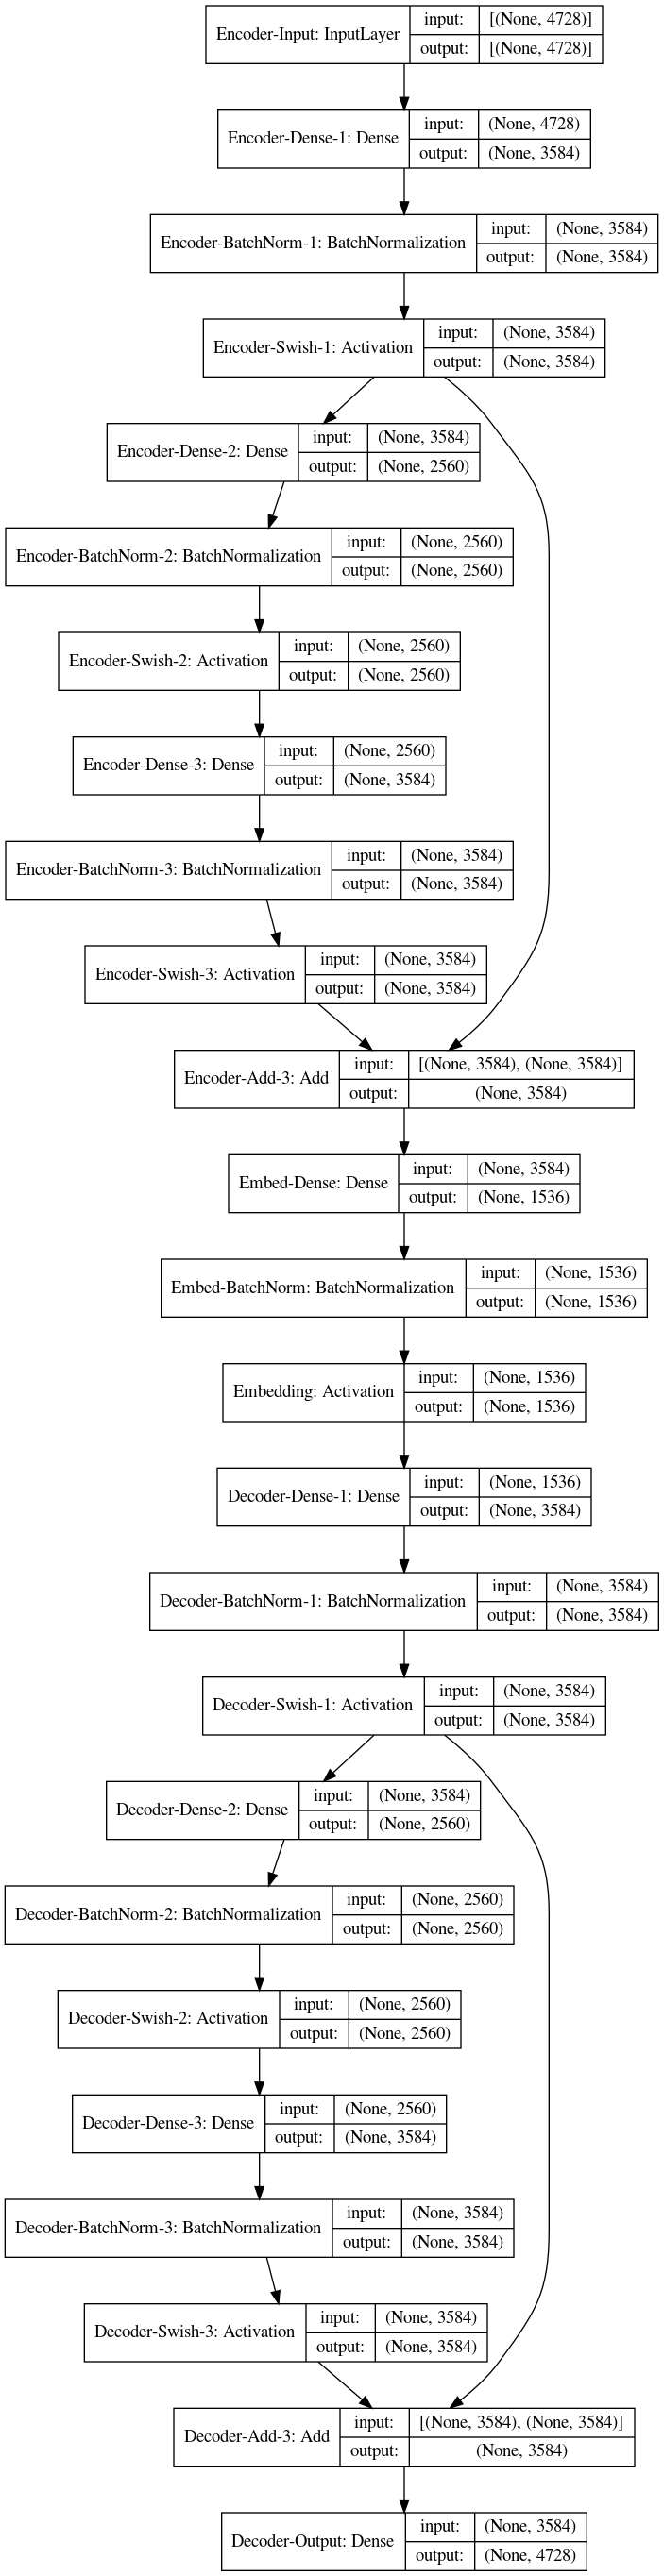

In [9]:
plot_model(
    model, to_file='./DAE_model.png', 
    show_shapes=True, show_layer_names=True
)

In [10]:
history = model.fit(
    Xtrain, 
    batch_size=mini_batch_size,
    epochs=275, 
    verbose=1, 
    workers=5,
    callbacks=[reduce_lr, early, chk_point], 
    validation_data=Xtest
)

Epoch 1/275
175/175 [==============================] - 56s 277ms/step - loss: 57.9610 - val_loss: 8.5457

Epoch 00001: val_loss improved from inf to 8.54568, saving model to ./DAE_model.h5
Epoch 2/275
175/175 [==============================] - 53s 297ms/step - loss: 5.4138 - val_loss: 2.2107

Epoch 00002: val_loss improved from 8.54568 to 2.21068, saving model to ./DAE_model.h5
Epoch 3/275
175/175 [==============================] - 48s 270ms/step - loss: 1.8030 - val_loss: 1.4949

Epoch 00003: val_loss improved from 2.21068 to 1.49493, saving model to ./DAE_model.h5
Epoch 4/275
175/175 [==============================] - 49s 272ms/step - loss: 3.5281 - val_loss: 2.5843

Epoch 00004: val_loss did not improve from 1.49493
Epoch 5/275
175/175 [==============================] - 49s 273ms/step - loss: 3.5186 - val_loss: 2.0421

Epoch 00005: val_loss did not improve from 1.49493
Epoch 6/275
175/175 [==============================] - 48s 272ms/step - loss: 1.6799 - val_loss: 1.6140

Epoch 0000

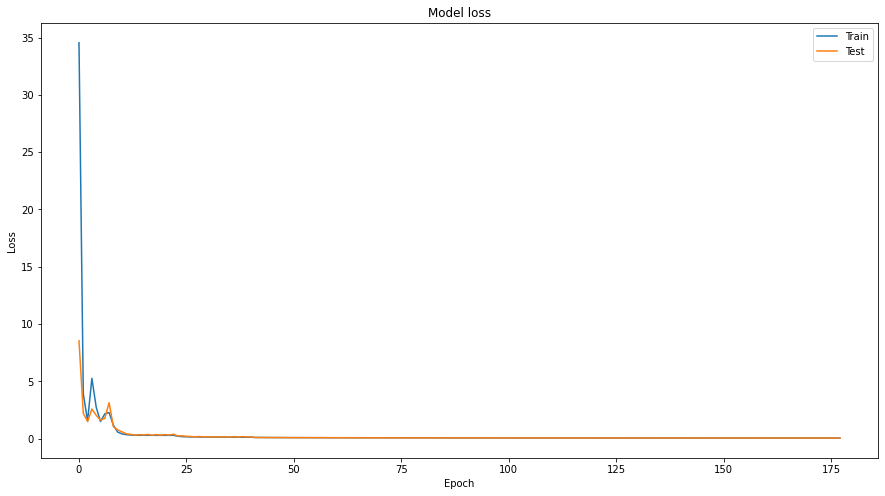

In [11]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Validate autoencoder output

In [12]:
model = load_model('./DAE_model.h5')
y_pred = model.predict(test_.values)
y_pred.shape

(7500, 4728)

In [13]:
test_.head()

,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,pkg_embed_7,...,sightseeing_embed_764,sightseeing_embed_765,sightseeing_embed_766,sightseeing_embed_767,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination
6014,0.163824,-0.523537,-1.160170,-0.084341,-1.743035,-1.466307,0.148289,-0.345926,-0.167707,-0.793757,...,0.949547,1.201094,-1.446104,0.518630,5.199338,-1.088723,-0.539431,-0.634851,-5.199338,0.087933
7518,-5.199338,5.199338,1.750222,0.124523,0.989697,0.288750,-0.877196,-0.546700,1.121060,1.579968,...,0.090452,1.824556,5.199337,-1.811457,-5.199338,-1.639539,-5.199338,-0.892038,0.908975,-5.199338
13157,-5.199338,5.199338,0.122393,-1.370966,-0.462622,-1.324959,-0.456891,-1.582067,-0.301856,0.655055,...,0.914679,1.057485,0.615024,-0.658043,-5.199338,0.212353,-0.300542,0.443149,-0.524976,-0.358833
2889,-5.199338,5.199338,-0.500324,-0.086674,0.475214,1.559802,-0.344033,-1.013881,-0.404817,0.061513,...,-0.627196,1.100140,1.107059,-0.408805,-5.199338,5.199338,0.395204,5.199338,0.908975,-0.513491
16260,0.163824,-0.523537,0.437538,0.048890,-0.104318,1.284944,0.026349,-0.512061,-1.455873,1.414575,...,-0.837339,1.378114,0.013796,-0.532190,5.199338,-0.188033,-0.981540,-5.199338,-5.199338,-1.031509


In [14]:
df = pd.DataFrame(y_pred, columns=test_.columns)
df.head()

,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,pkg_embed_7,...,sightseeing_embed_764,sightseeing_embed_765,sightseeing_embed_766,sightseeing_embed_767,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination
0,0.166111,-0.516297,-0.925973,0.004705,-1.322155,-1.393967,0.331140,0.186138,-0.155399,-0.368226,...,1.277621,1.428105,-1.599575,-0.015300,5.252991,-1.211914,-0.244091,-0.261001,-5.512223,0.419920
1,-5.101350,4.306497,1.735005,0.159615,1.399571,0.380532,-1.157776,-0.747298,1.264619,1.639161,...,0.145407,1.779847,5.158951,-1.773358,-5.345931,-2.153497,-5.147823,-0.850525,0.805454,-5.213621
2,-4.726061,4.694433,0.622802,-1.399632,-0.638206,-1.167798,-0.348265,-1.260174,-0.313982,0.794575,...,1.092094,1.168871,0.613076,-0.537064,-4.889027,0.378029,-0.330490,0.606863,-0.085748,-0.344810
3,-4.748716,4.474327,-0.456269,-0.005435,0.288650,1.529809,-0.779009,-0.913066,-0.300202,0.291133,...,-0.747440,1.018155,1.016145,-0.430067,-5.374101,6.167496,0.542600,6.053834,1.157052,-0.651201
4,0.921003,-0.787441,0.426585,0.357297,0.104136,1.013567,0.192197,-0.498604,-1.784033,1.529281,...,-0.826267,1.623414,-0.247888,-0.800691,3.269168,1.262629,-1.091618,-5.589039,-5.228150,-1.038529


In [15]:
mse = (np.square(test_.values - df.values)).mean()
print("MSE: {}".format(mse))

MSE: 0.0446411274545053
